C:\Users\Vansh Aggarwal\AppData\Local\Temp\ipykernel_25816\2522206064.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


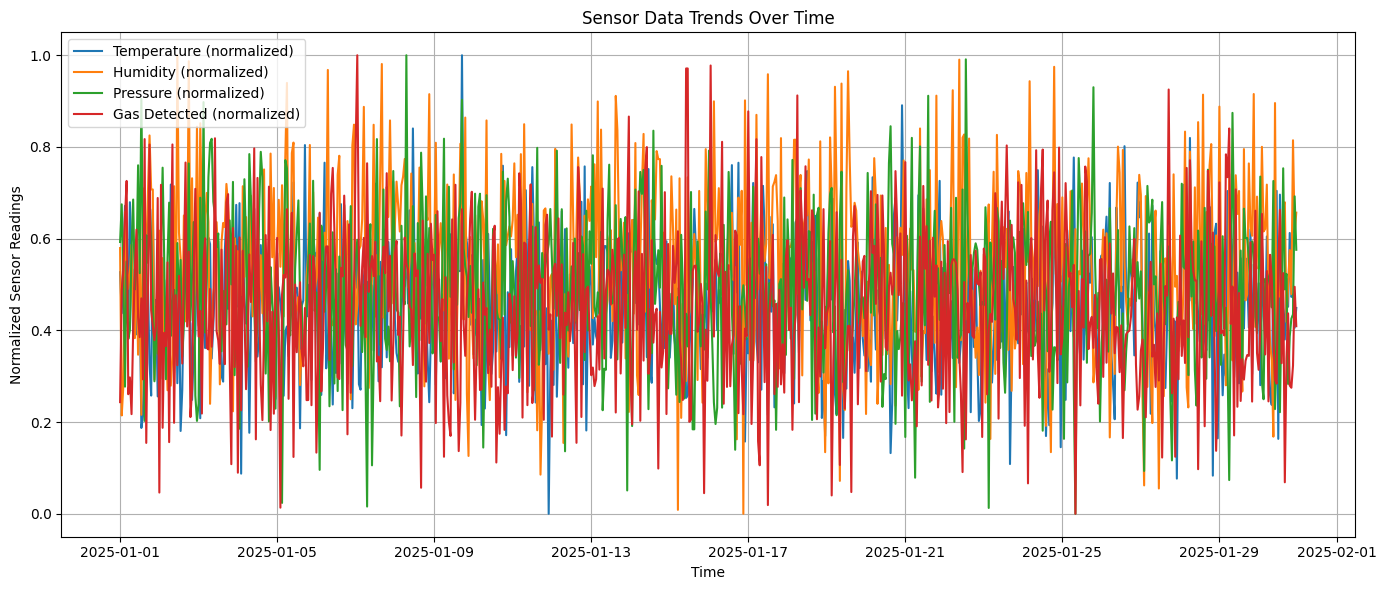

            timestamp  temperature_C  humidity_%  pressure_hPa  \
0 2025-01-01 00:00:00       0.526922    0.579538      0.592728   
1 2025-01-01 01:00:00       0.437412    0.214535      0.674914   
2 2025-01-01 02:00:00       0.548204    0.280009      0.515167   
3 2025-01-01 03:00:00       0.671595    0.658303      0.277287   
4 2025-01-01 04:00:00       0.423895    0.554770      0.550364   

   gas_detected_ppm material_type  risk_score risk_level  
0          0.243530          PETN           2        Low  
1          0.486876           TNT           2        Low  
2          0.531984           TNT           3        Low  
3          0.647017           TNT           9       High  
4          0.725936           TNT           3        Low  


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
np.random.seed(42)

# Simulate 30 days of hourly sensor data
timestamps = pd.date_range(start='2025-01-01', periods=720, freq='H')

# Simulate realistic sensor data
temperature = np.random.normal(loc=25, scale=4, size=720)         # in °C
humidity = np.random.normal(loc=60, scale=10, size=720)           # in %
pressure = np.random.normal(loc=1013, scale=5, size=720)          # in hPa
gas_ppm = np.abs(np.random.normal(loc=5, scale=2, size=720))      # in ppm, positive only

# Create material type and introduce some variety
material_types = np.random.choice(['TNT', 'RDX', 'PETN'], size=720)

# Assemble into DataFrame
data = pd.DataFrame({
    'timestamp': timestamps,
    'temperature_C': temperature,
    'humidity_%': humidity,
    'pressure_hPa': pressure,
    'gas_detected_ppm': gas_ppm,
    'material_type': material_types
})

# Introduce random missing values
for col in ['temperature_C', 'humidity_%', 'pressure_hPa', 'gas_detected_ppm']:
    missing_indices = np.random.choice(data.index, size=5, replace=False)
    data.loc[missing_indices, col] = np.nan

# Fill missing values using forward fill
data.fillna(method='ffill', inplace=True)

# Drop duplicates if any
data.drop_duplicates(inplace=True)

# Sort by timestamp
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.sort_values('timestamp', inplace=True)

# Normalize sensor data
scaler = MinMaxScaler()
scaled_columns = ['temperature_C', 'humidity_%', 'pressure_hPa', 'gas_detected_ppm']
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Visualize sensor trends
plt.figure(figsize=(14, 6))
plt.plot(data['timestamp'], data['temperature_C'], label='Temperature (normalized)')
plt.plot(data['timestamp'], data['humidity_%'], label='Humidity (normalized)')
plt.plot(data['timestamp'], data['pressure_hPa'], label='Pressure (normalized)')
plt.plot(data['timestamp'], data['gas_detected_ppm'], label='Gas Detected (normalized)')
plt.xlabel('Time')
plt.ylabel('Normalized Sensor Readings')
plt.title('Sensor Data Trends Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save cleaned & normalized data
data_path = "processed_sensor_data.csv"
data.to_csv(data_path, index=False)

# ------------------------------
# Rule-Based Risk Classification
# ------------------------------

def classify_risk(row):
    gas = row['gas_detected_ppm']
    temp = row['temperature_C']
    hum = row['humidity_%']
    pressure = row['pressure_hPa']

    if gas > 0.8 or temp > 0.75:
        return 'High'
    elif gas > 0.6 or temp > 0.6 or hum > 0.7:
        return 'Medium'
    else:
        return 'Low'

# Apply risk classification (initial)
data['risk_level'] = data.apply(classify_risk, axis=1)

# Save data with rule-based risk
updated_data_path = "processed_sensor_data_with_risk.csv"
data.to_csv(updated_data_path, index=False)

# ------------------------------------
# Score-Based Risk Level Classification
# ------------------------------------

def compute_risk_score(row):
    score = 0

    # Temperature contribution
    if row['temperature_C'] > 0.75:
        score += 3
    elif row['temperature_C'] > 0.6:
        score += 2
    elif row['temperature_C'] > 0.5:
        score += 1

    # Humidity contribution
    if row['humidity_%'] > 0.75:
        score += 2
    elif row['humidity_%'] > 0.6:
        score += 1

    # Pressure contribution (lower pressure = higher risk)
    if row['pressure_hPa'] < 0.3:
        score += 3
    elif row['pressure_hPa'] < 0.4:
        score += 2
    elif row['pressure_hPa'] < 0.5:
        score += 1

    # Gas detection contribution
    if row['gas_detected_ppm'] > 0.8:
        score += 4
    elif row['gas_detected_ppm'] > 0.6:
        score += 3
    elif row['gas_detected_ppm'] > 0.4:
        score += 2
    elif row['gas_detected_ppm'] > 0.2:
        score += 1

    return score

# Apply score calculation
data['risk_score'] = data.apply(compute_risk_score, axis=1)

# Classify based on score
def classify_by_score(score):
    if score >= 8:
        return 'High'
    elif score >= 4:
        return 'Medium'
    else:
        return 'Low'

data['risk_level'] = data['risk_score'].apply(classify_by_score)

# Save final dataset
final_data_path = "final_sensor_data_with_score_and_level.csv"
data.to_csv(final_data_path, index=False)

# Display a preview
print(data[['timestamp', 'temperature_C', 'humidity_%', 'pressure_hPa', 'gas_detected_ppm', 'material_type', 'risk_score', 'risk_level']].head())
